In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
db = pd.read_csv('diabetes.csv')

In [3]:
# sanity check that the dataset was read correctly from the csv
db.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

Display the number of observations in the dataset.

In [4]:
len(db)

768

Perform initial check for null values.

In [5]:
db.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Note that above, pandas returns that there are no null values in the dataset. However, this dataset has an irregular coding of null values as 0s instead of NaNs. These values exist in the glucose, blood pressure, skin thickness, insulin, and BMI columns. Therefore, we convert all 0 values in these columns to NaNs in order to get an accurate view of the number of null values for each feature.

In [6]:
db2 = db.copy(deep = True)
db2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = db2[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

db2.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

Impute missing values with the mean value for each feature.

In [7]:
db2['Glucose'].fillna(db2['Glucose'].mean(), inplace = True)
db2['BloodPressure'].fillna(db2['BloodPressure'].mean(), inplace = True)
db2['SkinThickness'].fillna(db2['SkinThickness'].mean(), inplace = True)
db2['Insulin'].fillna(db2['Insulin'].mean(), inplace = True)
db2['BMI'].fillna(db2['BMI'].mean(), inplace = True)

# sanity check that no null values remain
print(db2.isnull().sum())

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Observe feature distributions via histograms.

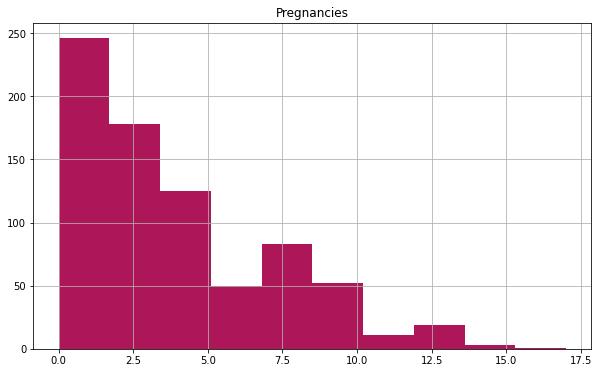

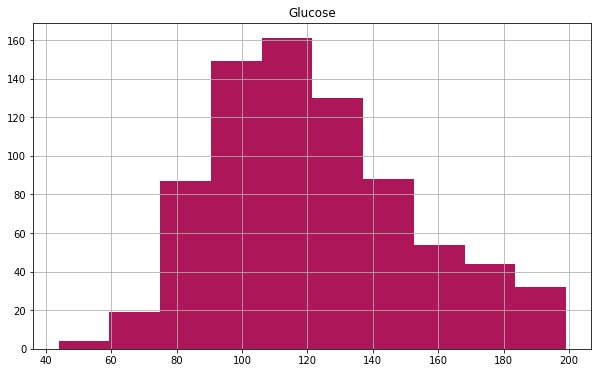

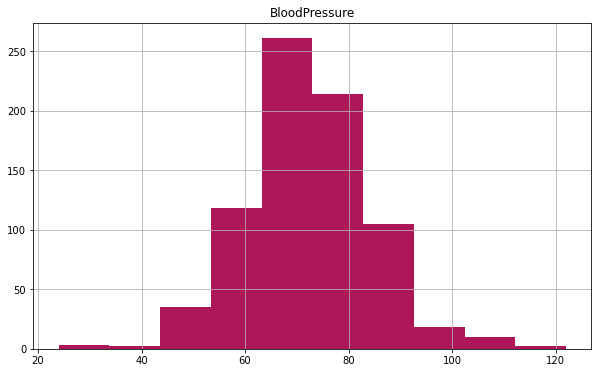

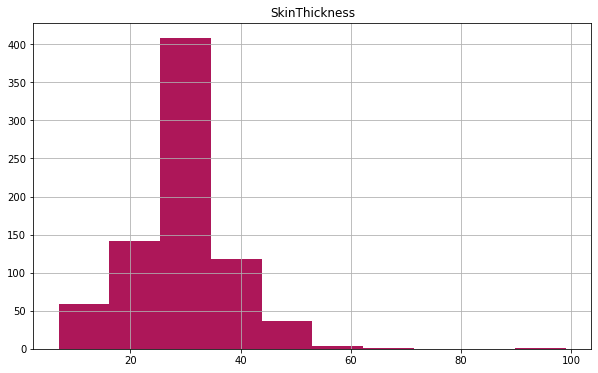

In [8]:
for col in db2.columns[:4]:
    db2.hist(column=col, figsize=(10,6), color='#ad1759')

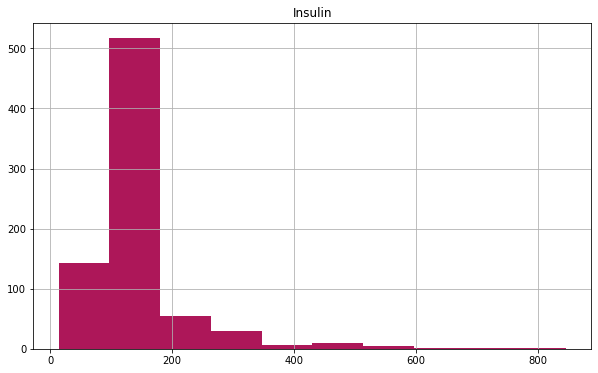

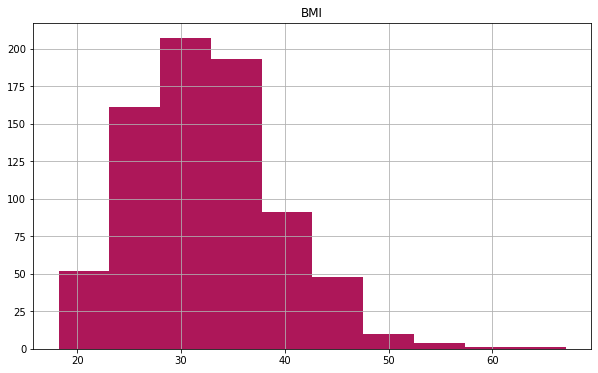

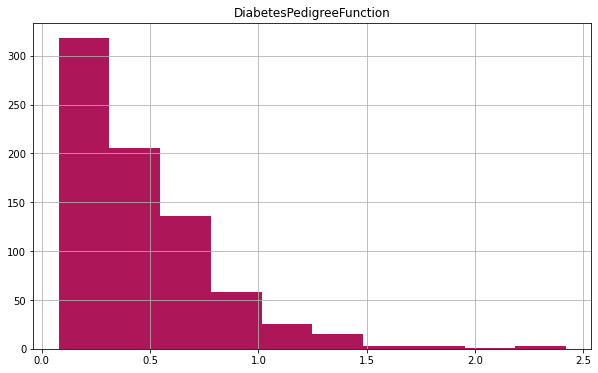

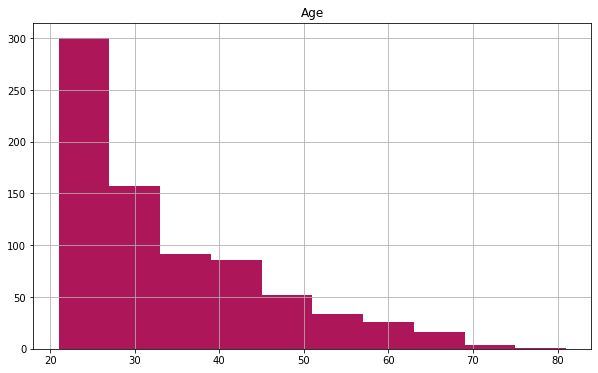

In [9]:
for col in db2.columns[4:8]:
    db2.hist(column=col, figsize=(10,6), color='#ad1759')

array([[<AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

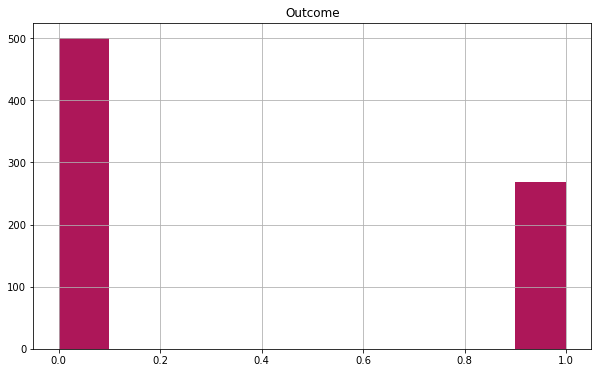

In [10]:
db2.hist(column='Outcome', figsize=(10,6), color='#ad1759')

Due to the imbalance of the classes resulting in the positive class being underrepresented in the dataset, it will be important to monitor confusion matrices/F1 scores moving forward to ensure that accuracy is not trivially achieved by the model through bias towards the negative class.

Observe correlation matrix of the features

<AxesSubplot:>

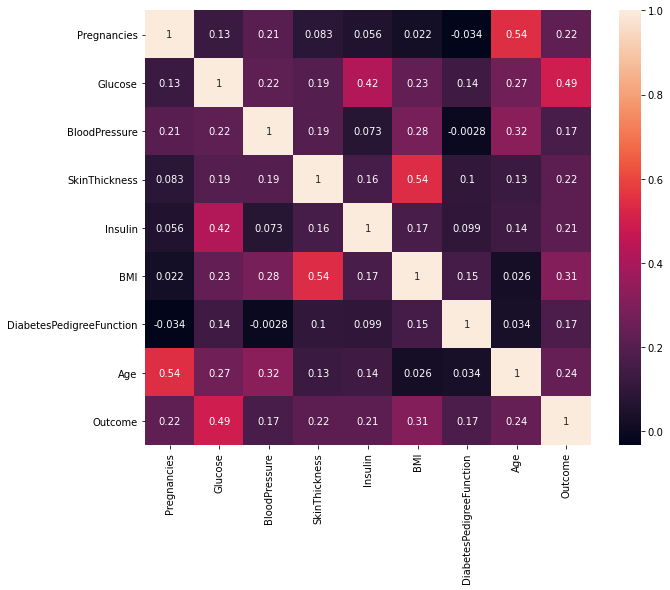

In [11]:
fig, ax = plt.subplots(figsize=(10,8))  
sns.heatmap(db2.corr(), annot=True, cmap ='rocket')

Unsurprisingly, glucose is shown to be significantly positively correlated with a positive outcome of diabetes. Interestingly, insulin is also shown to be positively correlated with glucose, but insulin itself has a much lower positive correlation with the diabetes outcome. However, it should be noted that a very large amount of insulin values were null values as reported above, so this may not be an accurate reflection of the true distribution in the population.

Following glucose, BMI has the next highest correlation with the diabetic outcome, followed by age, number of pregnancies, skin thickness, and insulin. The features with the lowest correlation with the outcome variable are blood pressure and the diabetes pedigree function; however, the correlation listed is not negligible.

Because the number of features is already relatively small, it is possible that feature removal is not necessary in this problem. To investigate further, a random forest classifier will be used in order to observe the feature importance ratings of the features list.

In [12]:
X = db2.drop('Outcome', axis=1).values
y = db2['Outcome'].values
feat_labels = db2.columns[:17]
forest = RandomForestClassifier(n_estimators=100, random_state=1)
forest.fit(X, y)
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

 1) Glucose                        0.247178
 2) BMI                            0.161648
 3) Age                            0.136025
 4) DiabetesPedigreeFunction       0.125494
 5) Insulin                        0.092139
 6) BloodPressure                  0.086892
 7) Pregnancies                    0.076297
 8) SkinThickness                  0.074326


The first three ranked features (glucose, BMI, age) are identical to the results of the correlation matrix. However, the diabetes pedigree function is rated next highest in importance, and blood pressure is similarly ranked higher by the classifier. Because these features likely contain some level of useful information for predicting the target variable, all features will be kept for model selection.

Next, we will normalize the data to ensure all features are on the same scale before model selection.

In [13]:
x = db2.values
mms = preprocessing.MinMaxScaler()
x_norm = mms.fit_transform(x)
db_norm = pd.DataFrame(x_norm)
db_norm.columns = db2.columns

In [14]:
# sanity check that features have been scaled to 0-1
db_norm.head()

Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin       BMI  \
0     0.352941  0.670968       0.489796       0.304348  0.170130  0.314928   
1     0.058824  0.264516       0.428571       0.239130  0.170130  0.171779   
2     0.470588  0.896774       0.408163       0.240798  0.170130  0.104294   
3     0.058824  0.290323       0.428571       0.173913  0.096154  0.202454   
4     0.000000  0.600000       0.163265       0.304348  0.185096  0.509202   

   DiabetesPedigreeFunction       Age  Outcome  
0                  0.234415  0.483333      1.0  
1                  0.116567  0.166667      0.0  
2                  0.253629  0.183333      1.0  
3                  0.038002  0.000000      0.0  
4                  0.943638  0.200000      1.0

Evaluate k-NN, naive bayes, decision tree, and random forest classifier performance on the dataset through stratified k-fold cross validation, where k=5.

First, evaluate k-NN with k = 10, 20, 30, 40, and 50 neighbors.

In [15]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

X = db_norm.drop('Outcome', axis=1).values
y = db_norm['Outcome'].values
for neighbors in [10, 20, 30, 40, 50]:
    f1 = []
    acc = []
    knn = KNeighborsClassifier(n_neighbors = neighbors)
    for (train_index, test_index) in kf.split(X, y):
        knn.fit(X[train_index], y[train_index])
        y_hat = knn.predict(X[test_index])
        f1 += [f1_score(y[test_index], y_hat, average='macro')]
        acc += [accuracy_score(y[test_index], y_hat)]
    print(f'f1 for knn (k={neighbors}): {np.mean(f1):.3f} {chr(177)} {np.std(f1):.3f}')
    print(f'acc for knn (k={neighbors}): {np.mean(acc):.3f} {chr(177)} {np.std(acc):.3f}')
    print()
print('Confusion matrix of final test fold:')
confusion_matrix(y[test_index], y_hat)

f1 for knn (k=10): 0.709 ± 0.033
acc for knn (k=10): 0.747 ± 0.031

f1 for knn (k=20): 0.715 ± 0.040
acc for knn (k=20): 0.758 ± 0.035

f1 for knn (k=30): 0.726 ± 0.035
acc for knn (k=30): 0.766 ± 0.031

f1 for knn (k=40): 0.716 ± 0.039
acc for knn (k=40): 0.763 ± 0.032

f1 for knn (k=50): 0.708 ± 0.046
acc for knn (k=50): 0.755 ± 0.037

Confusion matrix of final test fold:


array([[84, 16],
       [30, 23]])

The best performing model is k=30.

Next, evaluate Naive Bayes with var_smoothing = 1, 1e-2, 1e-4, 1e-8, and 1e-10.

In [16]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for smooth in np.logspace(0,-10,num=6):
    f1 = []
    acc = []
    gnb = GaussianNB(var_smoothing=smooth)
    for (train_index, test_index) in kf.split(X, y):
        gnb.fit(X[train_index], y[train_index])
        y_hat = gnb.predict(X[test_index])
        f1 += [f1_score(y[test_index], y_hat, average='macro')]
        acc += [accuracy_score(y[test_index], y_hat)]
    print(f'f1 for naive bayes (var_smoothing={smooth}):{np.mean(f1):.3f} {chr(177)} {np.std(f1):.3f}')
    print(f'acc for naive bayes (var_smoothing={smooth}):{np.mean(acc):.3f} {chr(177)} {np.std(acc):.3f}')
    print()
print('Confusion matrix of final test fold:')
confusion_matrix(y[test_index], y_hat)

f1 for naive bayes (var_smoothing=1.0):0.681 ± 0.031
acc for naive bayes (var_smoothing=1.0):0.746 ± 0.017

f1 for naive bayes (var_smoothing=0.01):0.713 ± 0.028
acc for naive bayes (var_smoothing=0.01):0.743 ± 0.029

f1 for naive bayes (var_smoothing=0.0001):0.712 ± 0.029
acc for naive bayes (var_smoothing=0.0001):0.742 ± 0.030

f1 for naive bayes (var_smoothing=1e-06):0.712 ± 0.029
acc for naive bayes (var_smoothing=1e-06):0.742 ± 0.030

f1 for naive bayes (var_smoothing=1e-08):0.712 ± 0.029
acc for naive bayes (var_smoothing=1e-08):0.742 ± 0.030

f1 for naive bayes (var_smoothing=1e-10):0.712 ± 0.029
acc for naive bayes (var_smoothing=1e-10):0.742 ± 0.030

Confusion matrix of final test fold:


array([[81, 19],
       [23, 30]])

The best performing model is var_smoothing=1e-2.

Next, evaluate decision tree with max_depth = 1, 2, 3, 4, 5, and 6.

In [17]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for depth in [1, 2, 3, 4, 5, 6]:
    f1 = []
    acc = []
    tree = DecisionTreeClassifier(random_state=1, class_weight='balanced', max_depth=depth)
    for (train_index, test_index) in kf.split(X, y):
        tree.fit(X[train_index], y[train_index])
        y_hat = tree.predict(X[test_index])
        f1 += [f1_score(y[test_index], y_hat, average='macro')]
        acc += [accuracy_score(y[test_index], y_hat)]
    print(f'f1 for decision tree (max_depth={depth}): {np.mean(f1):.3f} {chr(177)} {np.std(f1):.3f}')
    print(f'acc for decision tree (max_depth={depth}): {np.mean(acc):.3f} {chr(177)} {np.std(acc):.3f}')
    print()
print('Confusion matrix of final test fold:')
confusion_matrix(y[test_index], y_hat)

f1 for decision tree (max_depth=1): 0.691 ± 0.033
acc for decision tree (max_depth=1): 0.713 ± 0.034

f1 for decision tree (max_depth=2): 0.697 ± 0.040
acc for decision tree (max_depth=2): 0.732 ± 0.038

f1 for decision tree (max_depth=3): 0.688 ± 0.032
acc for decision tree (max_depth=3): 0.693 ± 0.033

f1 for decision tree (max_depth=4): 0.708 ± 0.024
acc for decision tree (max_depth=4): 0.717 ± 0.031

f1 for decision tree (max_depth=5): 0.686 ± 0.026
acc for decision tree (max_depth=5): 0.699 ± 0.031

f1 for decision tree (max_depth=6): 0.694 ± 0.018
acc for decision tree (max_depth=6): 0.710 ± 0.022

Confusion matrix of final test fold:


array([[76, 24],
       [17, 36]])

The model with the best f1 score is max_depth = 4, and best accuracy is max_depth = 2. Due to the accuracy being significantly better and the f1 score being comparable, I would select max_depth = 2.

Finally, evaluate random forest with num_estimators = 50, 100, 150, and 200.

In [18]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

for estimators in [50, 100, 150, 200]:
    f1 = []
    acc = []
    rf = RandomForestClassifier(n_estimators=estimators, random_state=1, class_weight='balanced')
    for (train_index, test_index) in kf.split(X, y):
        rf.fit(X[train_index], y[train_index])
        y_hat = rf.predict(X[test_index])
        f1 += [f1_score(y[test_index], y_hat, average='macro')]
        acc += [accuracy_score(y[test_index], y_hat)]
    print(f'f1 for random forest (n_estimators={estimators}): {np.mean(f1):.3f} {chr(177)} {np.std(f1):.3f}')
    print(f'acc for random forest (n_estimators={estimators}): {np.mean(acc):.3f} {chr(177)} {np.std(acc):.3f}')
    print()
print('Confusion matrix of final test fold:')
confusion_matrix(y[test_index], y_hat)

f1 for random forest (n_estimators=50): 0.720 ± 0.037
acc for random forest (n_estimators=50): 0.755 ± 0.033

f1 for random forest (n_estimators=100): 0.723 ± 0.039
acc for random forest (n_estimators=100): 0.755 ± 0.036

f1 for random forest (n_estimators=150): 0.727 ± 0.039
acc for random forest (n_estimators=150): 0.759 ± 0.034

f1 for random forest (n_estimators=200): 0.721 ± 0.037
acc for random forest (n_estimators=200): 0.754 ± 0.033

Confusion matrix of final test fold:


array([[83, 17],
       [25, 28]])

The best performing model is num_estimators=150.

Overall, the model with the best accuracy is k-NN with k=30 (acc=76.6), and the model with the best f1 score is random forest with num_estimators=150 (f1=72.7). Because the f1 score of the k-NN model is very close (f1=72.6) and the accuracy score of the random forest model has a larger gap (acc=75.9), I would select the k-NN model with k=30 as the best overall model. This selection is also influenced by k-NN being a more explainable model than RF.